## Introduction

This can be an attempt to look at the Barents Sea M term with the insights of the other notebook (I'm scared).

Note from An for reference (10/15):
- you can show us next time, try just 2x1 and 2x2. not sure what you mean by “original” advection, but those should close the xyz budgets (you can also verify), they are the standard we use , and if i recall correctly we used them when i first showed how budgets are closed

- and you can do first the way Helen mentioned using uvemass and vvelmass because then we are sure of units. if you use adv[x,y]_ then there is an extra step you have to take to make sure your unit is volume transports (which i believe you have already done in the past to get all the terms of total, diffusive, and surface tracer tendencies to units of volumetric transports)


What I'm not sure about is the T-S binning of the advection term itself. The T-S distribution at the gates will obviously not be the same as the one interior to the basin. My thoughts on this
- 1) is the overall (integrated) tendency from advection (cell-by-cell convergence) the same as the integrated tendency in T-S space when we look at the gates in isolation
- 2) can we verify that the M term calculated from ADV is the same as the ADV term calculated from the UVELMASS VVELMASS directly?
- 3) why are we accumulating transformations in ADV convergence for the cell-by cell plot?

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import BoundaryNorm

## What did we learn from the previous notebook?

- be very careful with indexing
- this will be the heat and salt transport timeseries that we did
- try to do this without any normalization by the T and S bin edges because this might be wrong
- start by making sure we use the entire basin and the gates are actually defined correctly based on this

In [3]:
# gates and series
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

choose_UV_bso3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_bso,x_bso):
    choose_UV_bso3d[:,i,j] = np.full(nz,choose_UV_bso[idx])
    idx += 1

choose_UV_sfj3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_sfj,x_sfj):
    choose_UV_sfj3d[:,i,j] = np.full(nz,choose_UV_sfj[idx])
    idx += 1

choose_UV_fjnz3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_fjnz,x_fjnz):
    choose_UV_fjnz3d[:,i,j] = np.full(nz,choose_UV_fjnz[idx])
    idx += 1

choose_UV_nzru3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_nzru,x_nzru):
    choose_UV_nzru3d[:,i,j] = np.full(nz,choose_UV_nzru[idx])
    idx += 1


# change the gate labels for SFJ because this was very wrong
result = choose_UV_sfj.copy()

# print(choose_UV_sfj)

# for i in [3,11,20,28,37]:
for i in [3,20,28,37]:     # these are the indices where we need both the x and y terms for the budget
    result[i] = "B"

# we also need to change manually some of the V terms
for i in [2,10,19,27,36]:
    result[i] = "H"

print()
# print(result)
choose_UV_sfj = result


# the BSO reading is also wrong
choose_UV_bso[20] = "H"
x_bso[x_bso == 161] = 162

In [4]:
# we should redefine gates I think
# start with NaNs (float array so NaN is valid)
gates = np.full((ny, nx), np.nan, dtype=float)

def _paint(x_idx, y_idx, value):
    x = np.asarray(x_idx, dtype=int)
    y = np.asarray(y_idx, dtype=int)
    # keep only points inside the domain
    m = (y >= 0) & (y < ny) & (x >= 0) & (x < nx)
    gates[y[m], x[m]] = value

# 1,2,3,4 for BSO, SFJ, FJNZ, NZRU
_paint(x_bso,  y_bso,  1)
_paint(x_sfj,  y_sfj,  2)
_paint(x_fjnz, y_fjnz, 3)
_paint(x_nzru, y_nzru, 4)

## Redefine mymsk based on the gates (this was wrong)

In [5]:
# cut off the edge of the Barents Sea that is should not be included
mymsk[:,84:110] = np.nan

(400.0, 600.0)

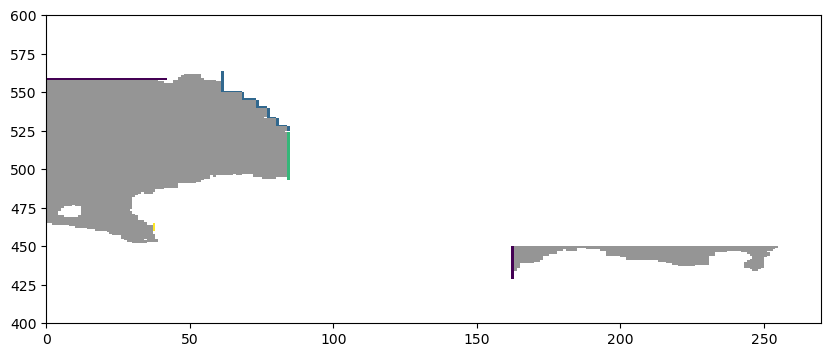

In [6]:
plt.pcolormesh(mymsk,cmap="Greys",vmin=-2,vmax=4)
plt.pcolormesh(gates)
plt.ylim(400,600)

## Load the orientation of the gates as we have done before (3d)

In [7]:
# double check the BSO again to make sure this is the correct way
# we cannot just use chooseUV for sfj because we need both ADVx and ADVy -- can I just do this manually?
# np.where(gates==2)

In [8]:
# choose_UV_bso # H indicates horizontal face (ie face 1) so we use ADVx (based on the lettering) and i (it is a western face)
# H means use the X term
# V means use the Y term

## Double check that the indices of the gates are in fact where we want to read from the M term

We do not want to double count the advection from next to the gate within these boxes.

In [9]:
gate_labels = ["BSO", "SFJ", "FJNZ","NZRU"]

In [10]:
## BSO is the only one split between face 1 and face 3 on the "west" and on the "north"
    # Face 1 H: i   and +ADVx
    # Face 3 V: j+1 and -ADVy

## For SFJ - these faces are on the "east" and "north" which we have labeled as H and V
    # these are stored in result which is a copy
    # H: i+1 and -ADVx
    # V: j+1 and -ADVy
    # B: i+1 and -ADVx and j+1 and -ADVy

## For FJNZ - these are on the "east" - also this is the primary gate we are interested in for the export of AW
    # H: i+1 and -ADVx

## For NZRU - these are on the "east" as well
    # H i+1 and -ADVx

In [11]:
# INDICES WE WANT TO READ FROM 
# make long sets of these so we can loop through later
ix_all = np.concatenate((x_bso,x_sfj,x_fjnz,x_nzru))
iy_all = np.concatenate((y_bso,y_sfj,y_fjnz,y_nzru))
choose_all = np.concatenate((choose_UV_bso,choose_UV_sfj,choose_UV_fjnz,choose_UV_nzru))

(1.0, 120.0)

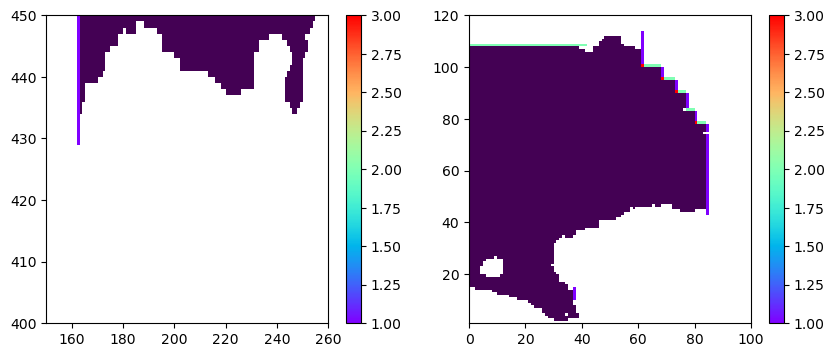

In [12]:
a = get_aste_faces(mymsk,nfx,nfy)
# b = get_aste_faces(gates,nfx,nfy)

# rather than plotting gates here I want to color these by the x,y indices so that we can double check again
# let's just add these as 1,2, or 3 for H V or B
gates_check = np.full((ny,nx),np.nan)
for j,i,c in zip(iy_all,ix_all,choose_all):
    if c == "H":
        gates_check[j,i] = 1
    elif c == "V":
        gates_check[j,i] = 2
    elif c == "B":
        gates_check[j,i] = 3

b = get_aste_faces(gates_check,nfx,nfy)


fig = plt.figure()

ax = plt.subplot(121)
ax.pcolormesh(a.f1[0])
cb = ax.pcolormesh(b.f1[0],cmap='rainbow',vmin=1,vmax=3)
plt.colorbar(cb)
ax.set_xlim(150, 260)
ax.set_ylim(400, 450)

ax = plt.subplot(122)
ax.pcolormesh(a.f3[0])
cb = ax.pcolormesh(b.f3[0], cmap='rainbow',vmin=1,vmax=3)
plt.colorbar(cb)
ax.set_xlim(0, 100)
ax.set_ylim(1, 120)

In [13]:
# we need to write out the indices we want to set at (ie the edge boxes where we have inflow)
x_set_bso = x_bso.copy() # this will be the same throughout for the bso
y_set_bso = y_bso.copy()
y_set_bso[21:] -= 1

# for sfj this will be longer than the original array but everything needs -= 1
x_set_sfj,y_set_sfj = np.array([]), np.array([])
for j,i,c in zip(y_sfj,x_sfj,choose_UV_sfj):
    if c == "H":
        # append j as is, append i-1
        y_set_sfj = np.append(y_set_sfj,j)
        x_set_sfj = np.append(x_set_sfj,i-1)
    elif c == "V":
        # append i as is, append j-1
        y_set_sfj = np.append(y_set_sfj,j-1)
        x_set_sfj = np.append(x_set_sfj,i)
    elif c == "B":
        # append twice -- once for i-1 and j, once for j-1 and i
        y_set_sfj = np.append(y_set_sfj,j-1)
        x_set_sfj = np.append(x_set_sfj,i)
        y_set_sfj = np.append(y_set_sfj,j)
        x_set_sfj = np.append(x_set_sfj,i-1)
        
# for fjnz and nzru these will all be -= 1 for i/x
x_set_fjnz = x_fjnz -1
y_set_fjnz = y_fjnz.copy()
x_set_nzru = x_nzru -1
y_set_nzru = y_nzru.copy()

In [14]:
# expand the sfj set to account for the change in indices

# If you already expanded x_set_sfj, y_set_sfj (including the two entries for each "B"),
# expand choose_UV_sfj to match:
def expand_choose_for_sfj(choose_src):
    out = []
    for c in choose_src:
        if c == "H":
            out.append("H")
        elif c == "V":
            out.append("V")
        elif c == "B":
            # MUST match how you appended indices for B:
            # you did: (j-1, i)  -> V   then  (j, i-1) -> H
            out.extend(["V", "H"])
    return np.array(out, dtype=object)

choose_set_sfj = expand_choose_for_sfj(choose_UV_sfj)

# (Optional) sanity check lengths align
assert len(choose_set_sfj) == len(x_set_sfj) == len(y_set_sfj), "SFJ choose/indices length mismatch"

In [15]:
# INDICES WE WANT TO WRITE TO
# make a similar arrangement of the set indices we want to set the values at in the C grid
ix_set_all = np.concatenate((x_set_bso,x_set_sfj,x_set_fjnz,x_set_nzru))
iy_set_all = np.concatenate((y_set_bso,y_set_sfj,y_set_fjnz,y_set_nzru))
choose_set_all = np.concatenate((choose_UV_bso,choose_set_sfj,choose_UV_fjnz,choose_UV_nzru))

##  Let's do this thing overall with UVEL and VVEL to see how to do this

I am scared of doing the normalization yet.

In [16]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2016"] = np.arange(1,3,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

2678400.0

In [17]:
# copy the TS binning here
# load the TS bins
####################################################################################################
print("doing volume")
# get the total volume
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
#print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    tmpvol = np.tile(mygrid['DXG'][np.newaxis,:,:],(50,1,1)) * np.tile(mygrid['DYG'][np.newaxis,:,:],(50,1,1)) * DRF3d

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))
#######
print("doing TS binning")
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
SALT = SALT.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

# create the bins of TS data
n_bins = 112

T_min, T_max = -2.0, 15.0
S_min, S_max = 28.0, 37.0

# edges and centers
binsTH_edges   = np.linspace(T_min, T_max, n_bins + 1)
binsSLT_edges  = np.linspace(S_min, S_max, n_bins + 1)
binsTH_centers = 0.5 * (binsTH_edges[:-1]  + binsTH_edges[1:])
binsSLT_centers= 0.5 * (binsSLT_edges[:-1] + binsSLT_edges[1:])

nT = nS = n_bins

# 2D bin grids
Tbin,     Sbin     = np.meshgrid(binsTH_edges,  binsSLT_edges)
Tbincent, Sbincent = np.meshgrid(binsTH_centers, binsSLT_centers)

# bin widths and reshaped versions (match downstream shape)
binwidthT = np.diff(binsTH_edges)
binwidthS = np.diff(binsSLT_edges)
dT, dS = np.meshgrid(binwidthT, binwidthS)
dT = dT.reshape(n_bins, n_bins, 1)
dS = dS.reshape(n_bins, n_bins, 1)

# bin theta and salt
binned_theta = bin_array(THETA, binsTH_edges).astype(float)
binned_theta[binned_theta == nT] = np.nan  # handle right-edge assignment
binned_theta[np.isnan(binned_theta)] = 0

binned_salinity = bin_array(SALT, binsSLT_edges).astype(float)
binned_salinity[binned_salinity == nS] = np.nan
binned_salinity[np.isnan(binned_salinity)] = 0

doing volume
doing TS binning


In [18]:
# copy the UVEL and VVEL calculation and grabbing of the gates here

# create the volume and bin this
DXG3d = np.tile(mygrid['DXG'][np.newaxis,:,:],(nz,1,1))
DYG3d = np.tile(mygrid['DYG'][np.newaxis,:,:],(nz,1,1))

# grab the UVEL and VVEL for this timestep
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])  # m/s
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)

In [20]:
# try to grab just the gateway terms (these are advection * rhoconst)

# I think it would make the most sense to do this as a dictionary for each of the gates
# each key in the dictionary will be the advective contribution of that gate
ADV_gates = {}

# WRITE THIS AGAIN SO I REMEMBER, WHEN H WE WANT TO CHOOSE THE X TERM WHEN V WE WANT TO CHOOSE THE Y TERM

# do for the BSO based on the y,x,and choose_UV
ADV_BSO = np.zeros((nz,ny,nx))
for j,i,direction in zip(y_bso,x_bso,choose_UV_bso):
    # if the direction is V (face3), we select the ADV from the indices of y_bso and x_bso but we want to put this at y_bso-1
    # this would be the face we tag for the T and S bins
    if direction == "H":
        ADV_BSO[:,j,i] += UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
    elif direction == "V":
        ADV_BSO[:,j-1,i] -= VVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]  # assuming we selected from the correct index of bso which I think we did
ADV_gates["BSO"] = ADV_BSO

# do for fjnz baed on the same thing, this will all be at H so we just need the x term, same for the last one
# these are all H -- use the ADVx term at i-1
ADV_FJNZ = np.zeros((nz,ny,nx))
for j,i,direction in zip(y_fjnz,x_fjnz,choose_UV_fjnz):
    ADV_FJNZ[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
ADV_gates["FJNZ"] = ADV_FJNZ

ADV_NZRU = np.zeros((nz,ny,nx))
for j,i,direction in zip(y_nzru,x_nzru,choose_UV_nzru):
    ADV_NZRU[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
ADV_gates["NZRU"] = ADV_NZRU

## SFJ looks wrong -- try again

# do for SFJ based on y,x, and choose_UV
ADV_SFJ = np.zeros((nz,ny,nx))  # we're setting this at the location we want to read from already in the z,y,x grid
for j,i,direction in zip(y_sfj,x_sfj,choose_UV_sfj):
    if direction == "H":
        ADV_SFJ[:,j,i-1] -= UVELMASS[:,j,i]  * DYG3d[:,j,i] * DRF3d[:,j,i]  # set at i-1 because we're taking at the right of the gate
    elif direction == "V":
        ADV_SFJ[:,j-1,i] -= VVELMASS[:,j,i]  * DYG3d[:,j,i] * DRF3d[:,j,i]   # set at j-1 because we're taking from the top of the gate
    elif direction == "B":
        # we need to add these to the cells below and the cells above
        ADV_SFJ[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
        ADV_SFJ[:,j-1,i] -= VVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
ADV_gates["SFJ"] = ADV_SFJ

In [21]:
# get the TS distribution for this
# this is where we try to put the salt terms into a TS mesh
# we need to go through the ADV points in each gate and add them to the TS bin at that point
binwidthTconst = np.nanmax(binwidthT)
binwidthSconst = np.nanmax(binwidthS)
norm = (binwidthTconst * binwidthSconst)
J_gates = np.zeros((4,nS,nT))

#########################################################################################################################
f3start = np.where(choose_UV_bso == "V")[0][0]   # we need to define this index for the start of face 3 for the BSO

for j,i,direction in zip(y_bso[:f3start],x_bso[:f3start],choose_UV_bso[:f3start]):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["BSO"][:,j,i]

    nzc = len(binned_theta[:,j,i][~np.isnan(binned_theta[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i])
        iSpt = int(binned_salinity[kc,j,i])
        J_gates[0,iSpt,iTpt] += (col[kc]) / norm

for j,i,direction in zip(y_bso[f3start:],x_bso[f3start:],choose_UV_bso[f3start:]):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["BSO"][:,j-1,i]

    nzc = len(binned_theta[:,j-1,i][~np.isnan(binned_theta[:,j-1,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j-1,i])
        iSpt = int(binned_salinity[kc,j-1,i])
        J_gates[0,iSpt,iTpt] += (col[kc]) / norm   # 

#########################################################################################################################
# do this for SFJ
for j,i,direction in zip(y_sfj,x_sfj,choose_UV_sfj):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["SFJ"][:,j-1,i-1]
    nzc = len(binned_theta[:,j-1,i-1][~np.isnan(binned_theta[:,j-1,i-1])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j-1,i-1])
        iSpt = int(binned_salinity[kc,j-1,i-1])
        J_gates[1,iSpt,iTpt] += (col[kc]) / norm

#########################################################################################################################
# same for FJNZ
for j,i,direction in zip(y_fjnz,x_fjnz,choose_UV_fjnz):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["FJNZ"][:,j,i-1]
    nzc = len(binned_theta[:,j,i-1][~np.isnan(binned_theta[:,j,i-1])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i-1])
        iSpt = int(binned_salinity[kc,j,i-1])
        J_gates[2,iSpt,iTpt] += (col[kc]) / norm

#########################################################################################################################
# same again for NZRU
for j,i,direction in zip(y_nzru,x_nzru,choose_UV_nzru):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["NZRU"][:,j,i-1]
    nzc = len(binned_theta[:,j,i-1][~np.isnan(binned_theta[:,j,i-1])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i-1])
        iSpt = int(binned_salinity[kc,j,i-1])
        J_gates[3,iSpt,iTpt] += (col[kc]) / norm


#############################################################################################################################
J_gates *= 1e-6

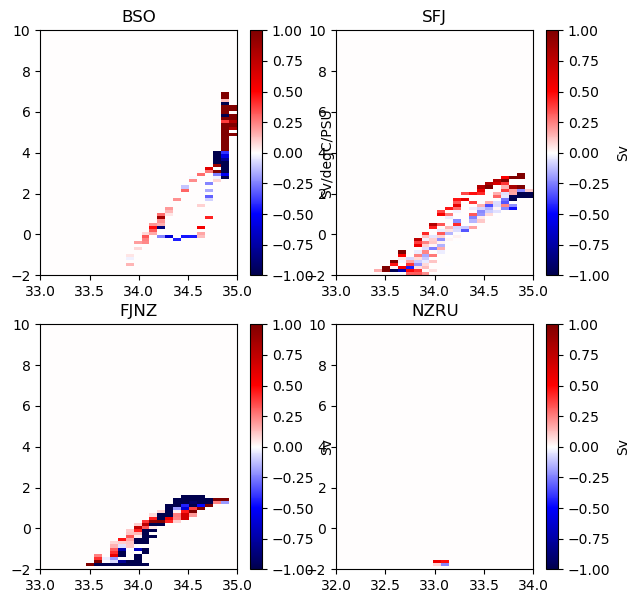

In [22]:
# plot my favorite 2x2 here for the four gates and see if this looks reasonable based on the output

vlev = 1

fig = plt.figure(figsize=(7,7))

ax = plt.subplot(221)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[0],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("BSO")
ax.set_xlim(33,35)
ax.set_ylim(-2,10)
plt.colorbar(cb,label="Sv/degC/PSU")

ax = plt.subplot(222)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[1],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("SFJ")
ax.set_xlim(33,35)
ax.set_ylim(-2,10)
plt.colorbar(cb,label="Sv")

ax = plt.subplot(223)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[2],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("FJNZ")
ax.set_xlim(33,35)
ax.set_ylim(-2,10)
plt.colorbar(cb,label="Sv")

ax = plt.subplot(224)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[3],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("NZRU")
ax.set_xlim(32,34)
ax.set_ylim(-2,10)
plt.colorbar(cb,label="Sv")

In [23]:
# let's do a nansum of this and see if it's the same (or at least similar) to the ADV J convergence
np.nansum(J_gates)
# the answer is no not at all

-15.713391152041558

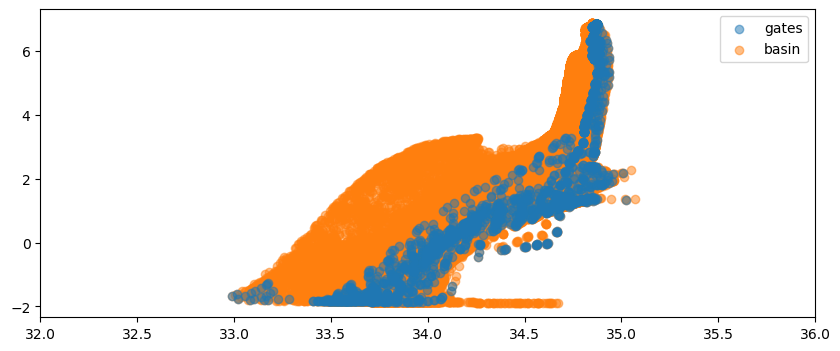

In [24]:
# plot a scatter of the TS at the gates and a TS of the basin itself
fig = plt.figure()

ax = plt.subplot(111)
# do a scatter of salt and theta from the check indices
tmpt = THETA[:,iy_set_all.astype(int),ix_set_all.astype(int)]
tmps = SALT[:,iy_set_all.astype(int),ix_set_all.astype(int)]
ax.scatter(tmps,tmpt,zorder=5,alpha=0.5,label="gates")

# do a scatter of the whole basin
tmpt = THETA[:,np.where(~np.isnan(mymsk))[0],np.where(~np.isnan(mymsk))[1]]
tmps = SALT[:,np.where(~np.isnan(mymsk))[0],np.where(~np.isnan(mymsk))[1]]
ax.scatter(tmps,tmpt,alpha=0.5,label="basin")
ax.set_xlim(32,36)

ax.legend(loc="best")

## Start with the salt budget

In [25]:
#############################################################################
print("doing salt budget")
# create the salt budget
AB_gT=0
AB_gS=0
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s
#print(np.nansum(SALTDR),dt)

tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)    # kg/m^3 * PSU.m/s * m^2 = g/s
#print(np.nansum(mk3D_mod(RAC,SALTDR)))
#print(np.nansum((SALTDR - AB_gS)))
#print( myparms['rhoconst'])
budgO = {}
budgO['saltfluxes'] = {}
budgI = {}
budgI['saltfluxes'] = {}
budgOI = {}

# ocean

budgO['saltfluxes']['tend'] = tmptend
budgO['salttend'] = np.nansum(tmptend,axis=0)


# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)

# reshape and get the faces
tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['saltfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['salthconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0))


# also do hconv for ADV and DF
tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

tmpUi = SIsal0 * myparms['rhoi'] * (DFxEHEFF + ADVxHEFF)
tmpVi = SIsal0 * myparms['rhoi'] * (DFyEHEFF + ADVyHEFF)
tmpUi = get_aste_faces(tmpUi,nfx,nfy)              
tmpVi = get_aste_faces(tmpVi,nfx,nfy)

budgI['salthconv'] = calc_UV_conv_mod(nfx,nfy,tmpUi, tmpVi)
budgOI['salthconv'] = (budgO['salthconv'] + budgI['salthconv'])


# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)


# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['saltzconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
budgI['saltzconv'] = -budgO['saltzconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['saltzconv']=-oceSflux


nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

#print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + sptop[:-1,:,:]
trWtop[0,:,:] = budgO['saltzconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # g/s
budgO['saltfluxes']['trWbot'] = trWbot     # g/s

budgI['saltfluxes']['trWtop'] = -RAC*0
budgI['saltfluxes']['trWbot'] = budgO['saltfluxes']['trWtop'][0,:,:]  # surface because ice

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']
budgO['saltzconv'] = RAC * budgO['saltzconv']   # g/s
budgI['saltzconv'] = RAC * budgI['saltzconv']   # g/s
budgOI['saltzconv'] = budgO['saltzconv'] + budgI['saltzconv']

# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a 

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell


tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this

doing salt budget


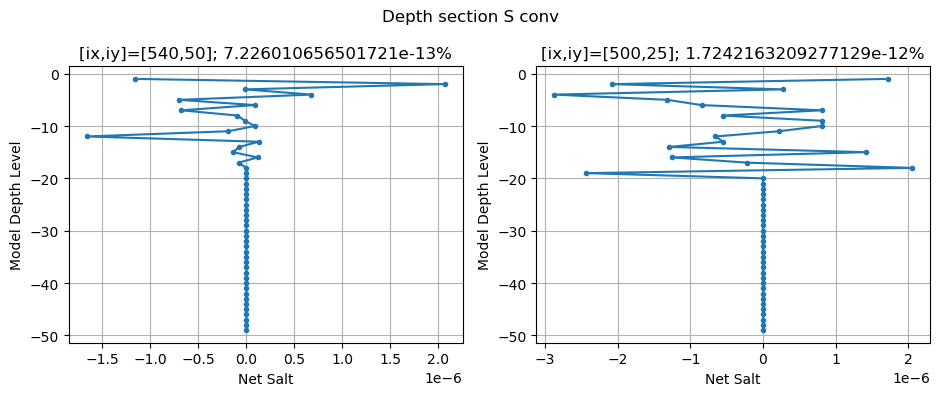

In [26]:
# Data variables (as given in your initial code)
a = budgO['saltfluxes']['tend']
b = budgO['saltfluxes']['ADV_Sconv']
c = budgO['saltfluxes']['DF_Sconv']
d = budgO['saltfluxes']['KPP_Sconv']
e = zconv_top_salt.reshape(1,ny,nx)                 # only at surface, is the surface forcing  ((SFLUX + oceSPflx) * RAC) in g/s
f = sptop                                            # oceSPtnd contribution from the ice

# pick one point from face 3 and one point from face 1
pt = np.array([[10,500,4],       # this is organized as x,y,z
               [220,445,10]])

pt = np.array([[10,500,4],       # this is organized as x,y,z
               [100,600,10]])

# 0 540 50
pt = np.array([[50,540,4],       # this is organized as x,y,z
               [100,600,10]])

y,x = 540,50

pt = np.array([[50,540,0],
               [25,500,0]])      # first is an extreme point, second is a more "normal" or midrange point for 03/2014


# also show the convergence at depth - I will make this a 1 by 2 plot so I can look at things easier

plt.figure(figsize=(9.5, 4))

aa = np.zeros((nz, 2))
plt.suptitle("Depth section S conv")


n = 1
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:, n-1] += (f[1:,iy,ix] - f[:-1,iy,ix])                                  # from the oceSPflx and oceSPtnd
aa[0, n-1] += f[0,iy,ix]
aa[0, n-1] -= zconv_top_salt[iy, ix]
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['saltfluxes']['zconv'][:,iy, ix]))}%")

n = 2
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:, n-1] += (f[1:,iy,ix] - f[:-1,iy,ix])                                  # from the oceSPflx and oceSPtnd
aa[0, n-1] += f[0,iy,ix]
aa[0, n-1] -= zconv_top_salt[iy, ix]

plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['saltfluxes']['zconv'][:,iy, ix]))}%")
    
        
plt.tight_layout()
plt.show()

In [27]:
# load the TS bins
####################################################################################################
print("doing volume")
# get the total volume
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
#print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    tmpvol = np.tile(mygrid['DXG'][np.newaxis,:,:],(50,1,1)) * np.tile(mygrid['DYG'][np.newaxis,:,:],(50,1,1)) * DRF3d

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))
#######
print("doing TS binning")
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
SALT = SALT.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

# create the bins of TS data
n_bins = 112

T_min, T_max = -2.0, 15.0
S_min, S_max = 28.0, 37.0

# edges and centers
binsTH_edges   = np.linspace(T_min, T_max, n_bins + 1)
binsSLT_edges  = np.linspace(S_min, S_max, n_bins + 1)
binsTH_centers = 0.5 * (binsTH_edges[:-1]  + binsTH_edges[1:])
binsSLT_centers= 0.5 * (binsSLT_edges[:-1] + binsSLT_edges[1:])

nT = nS = n_bins

# 2D bin grids
Tbin,     Sbin     = np.meshgrid(binsTH_edges,  binsSLT_edges)
Tbincent, Sbincent = np.meshgrid(binsTH_centers, binsSLT_centers)

# bin widths and reshaped versions (match downstream shape)
binwidthT = np.diff(binsTH_edges)
binwidthS = np.diff(binsSLT_edges)
dT, dS = np.meshgrid(binwidthT, binwidthS)
dT = dT.reshape(n_bins, n_bins, 1)
dS = dS.reshape(n_bins, n_bins, 1)

# bin theta and salt
binned_theta = bin_array(THETA, binsTH_edges).astype(float)
binned_theta[binned_theta == nT] = np.nan  # handle right-edge assignment
binned_theta[np.isnan(binned_theta)] = 0

binned_salinity = bin_array(SALT, binsSLT_edges).astype(float)
binned_salinity[binned_salinity == nS] = np.nan
binned_salinity[np.isnan(binned_salinity)] = 0

doing volume
doing TS binning


In [28]:
# PASTE THE KEY AGAIN HERE IN CASE I FORGET
## BSO is the only one split between face 1 and face 3 on the "west" and on the "north"
    # Face 1 H: i   and +ADVx
    # Face 3 V: j+1 and -ADVy

## For SFJ - these faces are on the "east" and "north" which we have labeled as H and V
    # these are stored in result which is a copy
    # H: i+1 and -ADVx
    # V: j+1 and -ADVy
    # B: i+1 and -ADVx and j+1 and -ADVy

## For FJNZ - these are on the "east" - also this is the primary gate we are interested in for the export of AW
    # H: i+1 and -ADVx

## For NZRU - these are on the "east" as well
    # H i+1 and -ADVx
    
# tmpADVx_SLT = ADVx_SLT.reshape(nz,ny,nx)
# print(tmpADVx_SLT[1,525,37] / SALT[1,525,37])

yw = 434
xw = 162
tmpADVx_SLT = ADVx_SLT.reshape(nz,ny,nx)


# let's print these to check them again
for i,j in zip(x_set_bso[:20],y_set_bso[:20]):
    print(ADV_BSO[1,j,i], tmpADVx_SLT[1,yw,xw] / SALT[1,yw,xw])

NameError: name 'tmpADVx_SLT' is not defined

In [24]:
# try to grab just the gateway terms (these are advection * rhoconst)

# I think it would make the most sense to do this as a dictionary for each of the gates
# each key in the dictionary will be the advective contribution of that gate
ADV_gates = {}

# reshape the ADVx terms
tmpADVx_SLT = ADVx_SLT.reshape(nz,ny,nx)
tmpADVy_SLT = ADVy_SLT.reshape(nz,ny,nx)

# WRITE THIS AGAIN SO I REMEMBER, WHEN H WE WANT TO CHOOSE THE X TERM WHEN V WE WANT TO CHOOSE THE Y TERM

# do for the BSO based on the y,x,and choose_UV
ADV_BSO = np.zeros((nz,ny,nx))
for j,i,direction in zip(y_bso,x_bso,choose_UV_bso):
    # if the direction is V (face3), we select the ADV from the indices of y_bso and x_bso but we want to put this at y_bso-1
    # this would be the face we tag for the T and S bins
    if direction == "H":
        ADV_BSO[:,j,i] += tmpADVx_SLT[:,j,i] * myparms['rhoconst']
    elif direction == "V":
        ADV_BSO[:,j-1,i] -= tmpADVy_SLT[:,j,i] * myparms['rhoconst']  # assuming we selected from the correct index of bso which I think we did
ADV_gates["BSO"] = ADV_BSO

# do for fjnz baed on the same thing, this will all be at H so we just need the x term, same for the last one
# these are all H -- use the ADVx term at i-1
ADV_FJNZ = np.zeros((nz,ny,nx))
for j,i,direction in zip(y_fjnz,x_fjnz,choose_UV_fjnz):
    ADV_FJNZ[:,j,i-1] -= tmpADVx_SLT[:,j,i] * myparms['rhoconst']
ADV_gates["FJNZ"] = ADV_FJNZ

ADV_NZRU = np.zeros((nz,ny,nx))
for j,i,direction in zip(y_nzru,x_nzru,choose_UV_nzru):
    ADV_NZRU[:,j,i-1] -= tmpADVx_SLT[:,j,i] * myparms['rhoconst']
ADV_gates["NZRU"] = ADV_NZRU

## SFJ looks wrong -- try again

# do for SFJ based on y,x, and choose_UV
ADV_SFJ = np.zeros((nz,ny,nx))  # we're setting this at the location we want to read from already in the z,y,x grid
for j,i,direction in zip(y_sfj,x_sfj,choose_UV_sfj):
    if direction == "H":
        ADV_SFJ[:,j,i-1] -= tmpADVx_SLT[:,j,i]  * myparms['rhoconst']  # set at i-1 because we're taking at the right of the gate
    elif direction == "V":
        ADV_SFJ[:,j-1,i] -= tmpADVy_SLT[:,j,i]  * myparms['rhoconst']   # set at j-1 because we're taking from the top of the gate
    elif direction == "B":
        # we need to add these to the cells below and the cells above
        ADV_SFJ[:,j,i-1] -= tmpADVx_SLT[:,j,i] * myparms['rhoconst']
        ADV_SFJ[:,j-1,i] -= tmpADVy_SLT[:,j,i] * myparms['rhoconst']
ADV_gates["SFJ"] = ADV_SFJ

(480.0, 570.0)

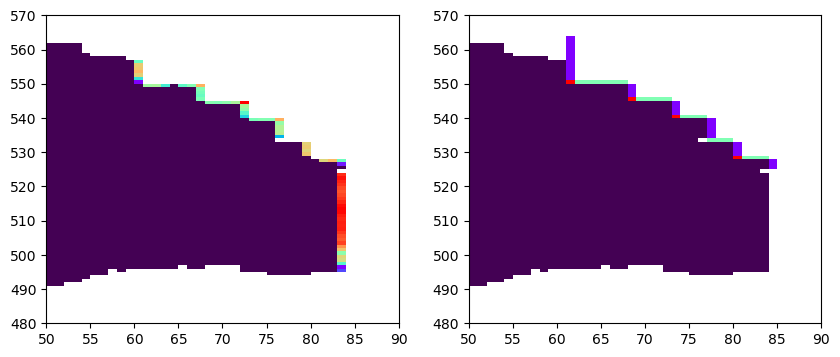

In [26]:
# try to make sure we set these correctly (again)

fig = plt.figure()

ax = plt.subplot(121)

ax.pcolormesh(mymsk)
tmp = ADV_gates['BSO'][3]
tmp[tmp==0] = np.nan
ax.pcolormesh(tmp,cmap='rainbow')

tmp = ADV_gates['SFJ'][0]
tmp[tmp==0] = np.nan
ax.pcolormesh(tmp,cmap='rainbow')

tmp = ADV_gates['FJNZ'][0]
tmp[tmp==0] = np.nan
ax.pcolormesh(tmp,cmap='rainbow')

tmp = ADV_gates['NZRU'][0]
tmp[tmp==0] = np.nan
plt.pcolormesh(tmp,cmap='rainbow')

ax.set_xlim(50,90)
ax.set_ylim(480,570)


ax = plt.subplot(122)

ax.pcolormesh(mymsk)
tmp = np.full((ny,nx),np.nan)
# plot just the sfj to make sure these are colored correctly
for j,i,mydir in zip(y_sfj,x_sfj,choose_UV_sfj):
    if mydir == "H":
        tmp[j,i] = 1
    if mydir == "V":
        tmp[j,i] = 2
    if mydir == "B":
        tmp[j,i] = 3
ax.pcolormesh(tmp,cmap='rainbow')
    

ax.set_xlim(50,90)
ax.set_ylim(480,570)

## Get the original budget in TS space

In [27]:
# plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])

In [28]:
print("doing JtermsS")
dstart = 0
dterm = 50
# initialize the J vectors for salt
JtermsS = np.zeros((5,nS,nT))

# get the values
aS = budgO['saltfluxes']['tend']
bS = budgO['saltfluxes']['ADV_Sconv']
cS = budgO['saltfluxes']['DF_Sconv']
dS = budgO['saltfluxes']['KPP_Sconv']
eS = zconv_top_salt.reshape(1,ny,nx)
fS = sptop

# do the same normalization everywhere so that we have it
binwidthTconst = np.nanmax(binwidthT)
binwidthSconst = np.nanmax(binwidthS)
norm = (binwidthTconst * binwidthSconst * myparms['rhoconst'])

points = np.argwhere(mymsk == 1)
ys = points[:,0]
xs = points[:,1]
for i,j in zip(ys,xs):

    # loop through the depths and add
    for k in range (dstart,dterm-1):
        iTpt = int(binned_theta[k,i,j])
        iSpt = int(binned_salinity[k,i,j])
    
        # save the J terms for here for the single point   
        JtendS = (aS[k,i,j]) / norm * 1e-6             # Sv
        JADVS = (bS[k,i,j]) / norm * 1e-6              # Sv
        JDFS = (cS[k,i,j]) / norm * 1e-6               # Sv
        JKPPS = (dS[k,i,j]) / norm * 1e-6              # Sv

        # surface term will be unique
        if k == 0:
            JsurfS = (eS[k,i,j] - fS[k+1,i,j]) / norm * 1e-6  # Sv
        else:
            JsurfS = -(fS[k,i,j] - fS[k-1,i,j]) / norm * 1e-6  # Sv

        # set these in meshes so we can plot
        c = 0
        for valS in (np.array([JtendS,JADVS,JDFS,JKPPS,JsurfS])):
            #print(valT)
            JtermsS[c,iSpt,iTpt] += valS
            c += 1

# we will not print all terms here -- overkill
print("total residual",np.nansum(JtermsS[0] - JtermsS[1] - JtermsS[2] - JtermsS[3] - JtermsS[4]))#,"Sv/degC")

doing JtermsS
total residual -1.0981053174869047


(60.0, 105.0)

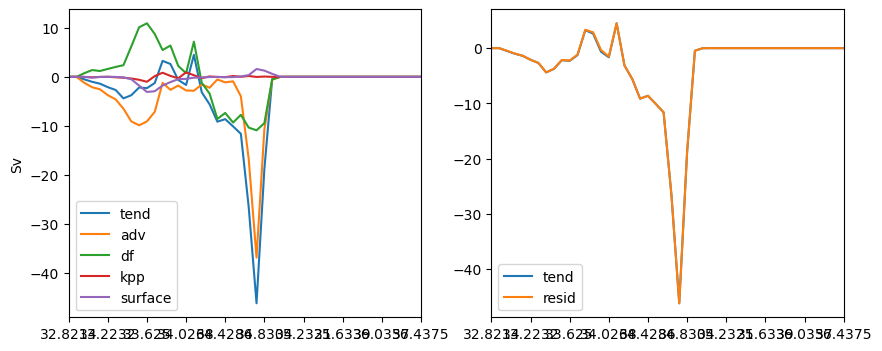

In [29]:

# formatter: map integer index -> binsSLT_edges[index]
def idx_to_bins_formatter(edges):
    def _fmt(x, pos):
        i = int(round(x))
        if 0 <= i < len(edges):
            return f"{edges[i]:g}"
        return ""
    return FuncFormatter(_fmt)

labels = np.array(["tend","adv","df","kpp","surface"])
fig = plt.figure()

# --- left subplot ---
ax = plt.subplot(121)
resid = np.zeros((nS))
for i in range(5):
    plotthis = np.nansum(JtermsS[i], axis=1)  # length nS (indices 0..nS-1)
    if i > 0:
        resid += plotthis
    ax.plot(plotthis, label=labels[i])

ax.set_ylabel("Sv")
ax.set_xlim(-0.5, nS - 0.5)                     # keep ticks aligned to integer indices
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(idx_to_bins_formatter(binsSLT_edges))
ax.legend(loc="best")
ax.set_xlim(60,105)

# --- right subplot ---
ax2 = plt.subplot(122)
ax2.plot(np.nansum(JtermsS[0], axis=1), label="tend")
ax2.plot(resid, label="resid")
ax2.set_xlim(-0.5, nS - 0.5)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_formatter(idx_to_bins_formatter(binsSLT_edges))
ax2.legend(loc="best")
ax2.set_xlim(60,105)

In [30]:
# get the J terms from the gate(s) to compare it 

# the terms in ADV_gates at this moment are in g/s

In [31]:
# I think we should do each of the gates separately because this doesn't make sense otherwise as we need x-1 and y+1 for any
# recall the key again 

# PASTE THE KEY AGAIN HERE IN CASE I FORGET
## BSO is the only one split between face 1 and face 3 on the "west" and on the "north"
    # Face 1 H: i   and +ADVx
    # Face 3 V: j+1 and -ADVy

## For SFJ - these faces are on the "east" and "north" which we have labeled as H and V
    # these are stored in result which is a copy
    # H: i+1 and -ADVx
    # V: j+1 and -ADVy
    # B: i+1 and -ADVx and j+1 and -ADVy

## For FJNZ - these are on the "east" - also this is the primary gate we are interested in for the export of AW
    # H: i+1 and -ADVx

## For NZRU - these are on the "east" as well
    # H i+1 and -ADVx

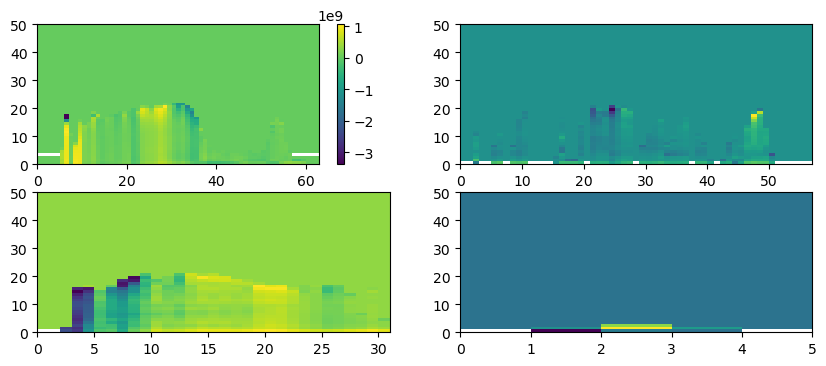

In [32]:
# check the ADV gates again so I remember which index to grab from
fig = plt.figure()

ax = plt.subplot(221)
mybso = ADV_gates["BSO"][:,y_bso,x_bso]
f3start = np.where(choose_UV_bso == "V")[0][0]
mybso[:,f3start:] = ADV_gates["BSO"][:,y_bso[f3start:]-1,x_bso[f3start:]]
cb = ax.pcolormesh(mybso)
plt.colorbar(cb)

ax = plt.subplot(222)
mysfj = ADV_gates["SFJ"][:,y_sfj-1,x_sfj-1]
ax.pcolormesh(mysfj)

ax = plt.subplot(223)
myfjnz = ADV_gates["FJNZ"][:,y_fjnz,x_fjnz-1]
ax.pcolormesh(myfjnz)

ax = plt.subplot(224)
mynzru = ADV_gates["NZRU"][:,y_nzru,x_nzru-1]
ax.pcolormesh(mynzru)

In [33]:
# Compute distances dynamically for each gate
gate_distances = {}

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_bso, y_bso, choose_UV_bso), 
                                                                (x_sfj, y_sfj, choose_UV_sfj), 
                                                                (x_fjnz, y_fjnz, choose_UV_fjnz),
                                                                (x_nzru, y_nzru, choose_UV_nzru)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

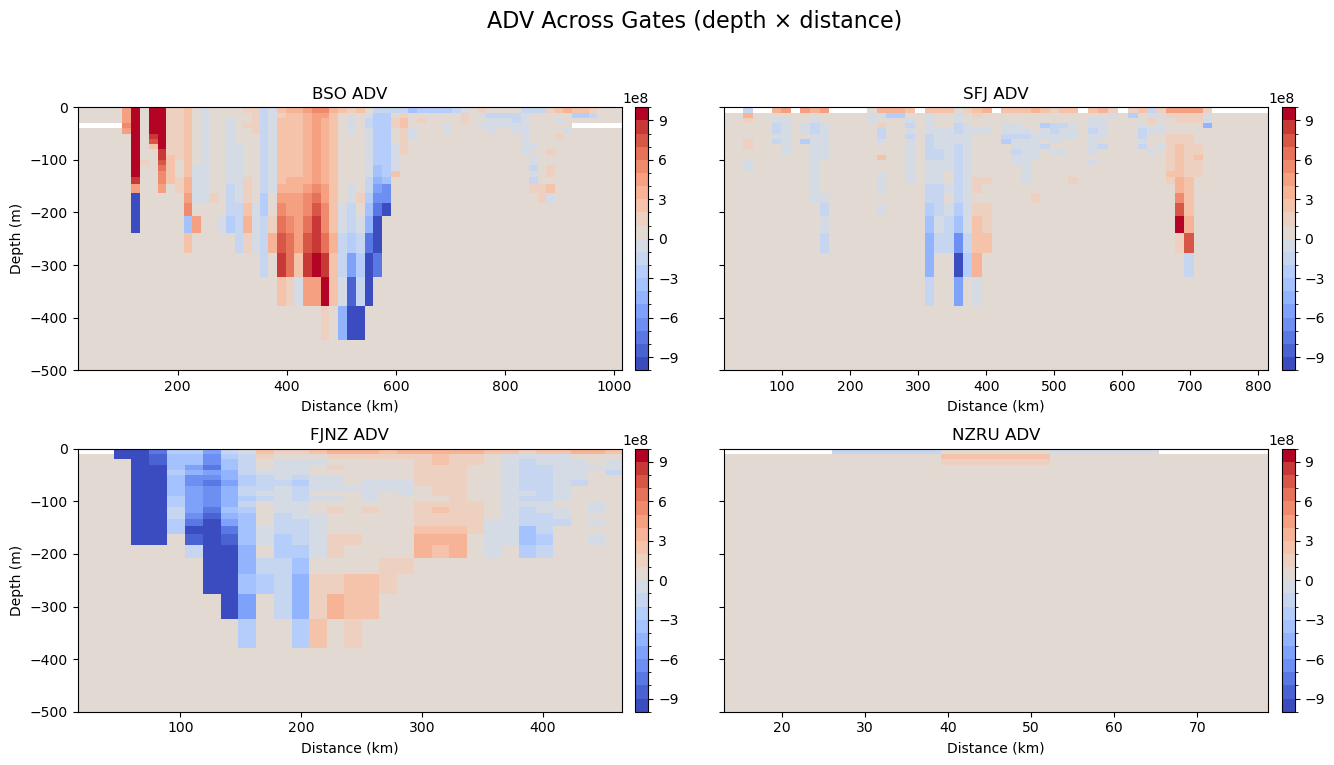

In [34]:
# ---- Edges from distances and DRF ------------------------------------------
# Depth edges: top at 0 m, increasing negative downward
y_vals  = -np.cumsum(mygrid['DRF'])          # (nz,)
y_edges = np.concatenate([[0], y_vals])      # (nz+1,)

def x_edges_from_dist(X):
    """Build x-edges for pcolormesh from center coords X (in km)."""
    if len(X) < 2:
        raise ValueError("Need ≥2 distance points to form x-edges.")
    dx_last = X[-1] - X[-2]
    return np.concatenate([X, [X[-1] + dx_last]])

# Distances per gate (in km)
X_bso  = gate_distances["BSO"]
X_sfj  = gate_distances["SFJ"]
X_fjnz = gate_distances["FJNZ"]
X_nzru = gate_distances["NZRU"]

xE_bso  = x_edges_from_dist(X_bso)
xE_sfj  = x_edges_from_dist(X_sfj)
xE_fjnz = x_edges_from_dist(X_fjnz)
xE_nzru = x_edges_from_dist(X_nzru)

# ---- Plot -------------------------------------------------------------------

bounds = np.linspace(-1e9, 1e9, 21)   # adjust to your data range/units
cmap   = plt.get_cmap('coolwarm')
norm   = BoundaryNorm(bounds, ncolors=cmap.N)

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

# BSO
ax = axes[0, 0]
im = ax.pcolormesh(xE_bso, y_edges, mybso, cmap=cmap, norm=norm, shading='auto')
ax.set_title("BSO ADV")
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Depth (m)")
ax.set_ylim(-500, 0)
fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)

# SFJ
ax = axes[0, 1]
im = ax.pcolormesh(xE_sfj, y_edges, mysfj, cmap=cmap, norm=norm, shading='auto')
ax.set_title("SFJ ADV")
ax.set_xlabel("Distance (km)")
ax.set_ylim(-500, 0)
fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)

# FJNZ
ax = axes[1, 0]
im = ax.pcolormesh(xE_fjnz, y_edges, myfjnz, cmap=cmap, norm=norm, shading='auto')
ax.set_title("FJNZ ADV")
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Depth (m)")
ax.set_ylim(-500, 0)
fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)

# NZRU
ax = axes[1, 1]
im = ax.pcolormesh(xE_nzru, y_edges, mynzru, cmap=cmap, norm=norm, shading='auto')
ax.set_title("NZRU ADV")
ax.set_xlabel("Distance (km)")
ax.set_ylim(-500, 0)
fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)

fig.suptitle("ADV Across Gates (depth × distance)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig("gate_adv_dist_depth_2x2.png", dpi=300)
# plt.show()


In [35]:
hfC1 = mygrid['hFacC']
hfC1[hfC1<1] = 1
binned_theta *= hfC1
binned_salinity *= hfC1

J_gates = np.zeros((4,nS,nT))

In [36]:
# this is where we try to put the salt terms into a TS mesh
# we need to go through the ADV points in each gate and add them to the TS bin at that point
binwidthTconst = np.nanmax(binwidthT)
binwidthSconst = np.nanmax(binwidthS)
norm = (binwidthTconst * binwidthSconst * myparms['rhoconst'])

#########################################################################################################################
f3start = np.where(choose_UV_bso == "V")[0][0]   # we need to define this index for the start of face 3 for the BSO

for j,i,direction in zip(y_bso[:f3start],x_bso[:f3start],choose_UV_bso[:f3start]):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["BSO"][:,j,i]

    nzc = len(binned_theta[:,j,i][~np.isnan(binned_theta[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i])
        iSpt = int(binned_salinity[kc,j,i])
        J_gates[0,iSpt,iTpt] += (col[kc]) / norm

for j,i,direction in zip(y_bso[f3start:],x_bso[f3start:],choose_UV_bso[f3start:]):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["BSO"][:,j-1,i]

    nzc = len(binned_theta[:,j-1,i][~np.isnan(binned_theta[:,j-1,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j-1,i])
        iSpt = int(binned_salinity[kc,j-1,i])
        J_gates[0,iSpt,iTpt] += (col[kc]) / norm   # 

#########################################################################################################################
# do this for SFJ
for j,i,direction in zip(y_sfj,x_sfj,choose_UV_sfj):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["SFJ"][:,j-1,i-1]
    nzc = len(binned_theta[:,j-1,i-1][~np.isnan(binned_theta[:,j-1,i-1])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j-1,i-1])
        iSpt = int(binned_salinity[kc,j-1,i-1])
        J_gates[1,iSpt,iTpt] += (col[kc]) / norm

#########################################################################################################################
# same for FJNZ
for j,i,direction in zip(y_fjnz,x_fjnz,choose_UV_fjnz):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["FJNZ"][:,j,i-1]
    nzc = len(binned_theta[:,j,i-1][~np.isnan(binned_theta[:,j,i-1])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i-1])
        iSpt = int(binned_salinity[kc,j,i-1])
        J_gates[2,iSpt,iTpt] += (col[kc]) / norm

#########################################################################################################################
# same again for NZRU
for j,i,direction in zip(y_nzru,x_nzru,choose_UV_nzru):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["NZRU"][:,j,i-1]
    nzc = len(binned_theta[:,j,i-1][~np.isnan(binned_theta[:,j,i-1])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i-1])
        iSpt = int(binned_salinity[kc,j,i-1])
        J_gates[3,iSpt,iTpt] += (col[kc]) / norm


#############################################################################################################################
J_gates *= 1e-6

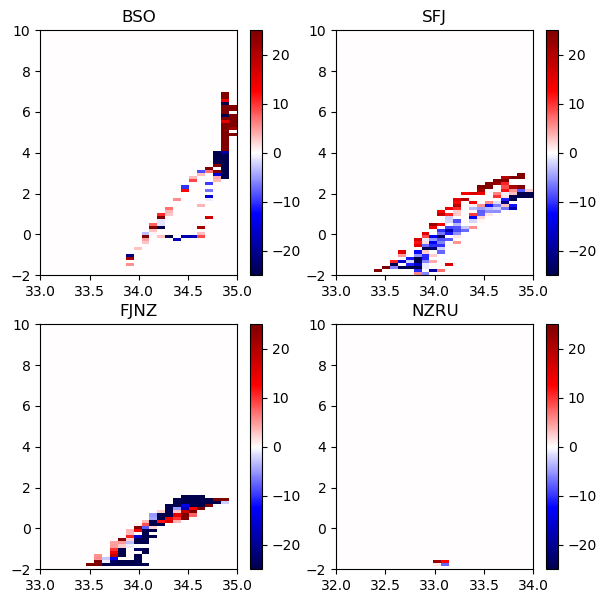

In [37]:
fig = plt.figure(figsize=(7,7))

ax = plt.subplot(221)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[0],cmap='seismic',vmin=-25,vmax=25)
ax.set_title("BSO")
ax.set_xlim(33,35)
ax.set_ylim(-2,10)
plt.colorbar(cb)

ax = plt.subplot(222)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[1],cmap='seismic',vmin=-25,vmax=25)
ax.set_title("SFJ")
ax.set_xlim(33,35)
ax.set_ylim(-2,10)
plt.colorbar(cb)

ax = plt.subplot(223)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[2],cmap='seismic',vmin=-25,vmax=25)
ax.set_title("FJNZ")
ax.set_xlim(33,35)
ax.set_ylim(-2,10)
plt.colorbar(cb)

ax = plt.subplot(224)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[3],cmap='seismic',vmin=-25,vmax=25)
ax.set_title("NZRU")
ax.set_xlim(32,34)
ax.set_ylim(-2,10)
plt.colorbar(cb)

(-2.0, 10.0)

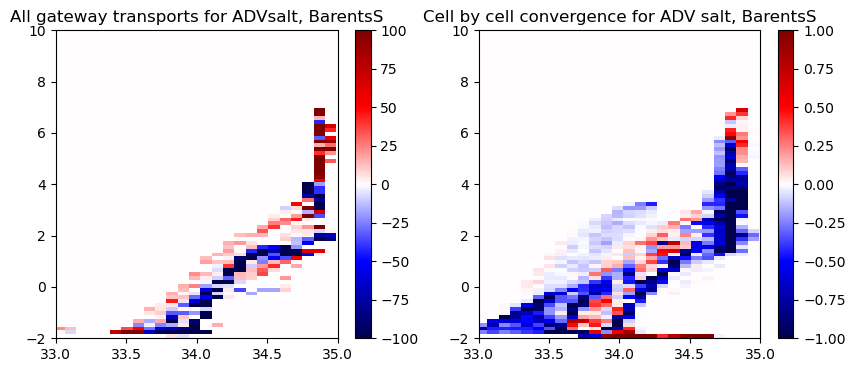

In [40]:
fig = plt.figure(figsize = (10,4,))

ax = plt.subplot(121)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(J_gates,axis=0),cmap='seismic',vmin=-1e2,vmax=1e2)
ax.set_title("All gateway transports for ADVsalt, BarentsS")
plt.colorbar(cb)
ax.set_xlim(33,35)
ax.set_ylim(-2,10)

ax = plt.subplot(122)
cb = ax.pcolormesh(Sbin,Tbin,JtermsS[1],cmap='seismic',vmin=-1,vmax=1)
ax.set_title("Cell by cell convergence for ADV salt, BarentsS")
plt.colorbar(cb)
ax.set_xlim(33,35)
ax.set_ylim(-2,10)

In [1]:
print(np.nansum(J_gates))
print(np.nansum(JtermsS[1]))

NameError: name 'np' is not defined

## this still did not work. can we try again a very simple budget at the gate for fjnz -2